In [1]:
import tensorflow as tf

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import shutil

### Load Ground truth CSV

In [2]:
#Load ground truth CSV
gt_df=pd.read_csv('../.keras/datasets/ISIC_2019_Training_GroundTruth.csv')
gt_df.head(2)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
total_imgs = len(gt_df)
total_imgs

25331

In [4]:
src_dir="../.keras/datasets/ISIC_2019_Training_Input"

In [5]:
# gt_df.dtypes
#get class names
gt_columns=gt_df.columns
classnames=gt_columns[1:]
classnames[0]

'MEL'

### Split dataframe into k fold

In [6]:
def train_test_val(n,split_ratio, dataset, val=True):    
    rng=np.random.default_rng() #for reproducibility
    random_idx = rng.choice(n, size=n, replace=False) # returns a numpy array, shuffles the index based on n   
    test_end = int(split_ratio[1]*n)
    if(val):
        test_end = int(split_ratio[1]*n) // 2
        test_idx = random_idx[:test_end]
        val_idx = random_idx[test_end:(test_end*2)]
        train_idx = random_idx[(test_end*2):] 
        return dataset.iloc[train_idx,:], dataset.iloc[test_idx,:],dataset.iloc[val_idx,:]

    test_idx = random_idx[:test_end]
    train_idx = random_idx[test_end:]
    return dataset.iloc[train_idx,:], dataset.iloc[test_idx,:] 

def gen_class_idx(n):
    #returns idx for a dataset 
    rng=np.random.default_rng() #for reproducibility
    # returns a numpy array, shuffles the index based on number of images   
    random_idx = rng.choice(n, size=n, replace=False)
    return random_idx

def k_fold_split(k,dataframe):
    n = len(dataset)
    class_idx = gen_class_idx(n)
    fold_ds = list()
    start=0
    end=0
    idx =[]
    num_in_fold = n//k
    for i in range(k):
        end = num_in_fold*(i+1)
        if(num_in_fold<=0):
            idx =[]
        else:    
            if(i<(k-1)):
                idx = class_idx[start:end]
            else:
                idx = class_idx[start:]
        start = num_in_fold*(i+1)
        fold_ds.append(dataset.values[idx]) 
      
    return fold_ds     

In [7]:
# class_ds_num = np.zeros((9,3),dtype="float")
# split_ratio = [0.7,0.3]

# dataset = gt_df[gt_df[classnames[0]]==1.0]
# train_ds,test_ds,val_ds = train_test_val(len(dataset),split_ratio, dataset)
# class_ds_num[0,:] = [len(train_ds),len(test_ds),len(val_ds)]

# i=1
# for classname in classnames[1:]:
#     dataset = gt_df[gt_df[classname]==1.0]
    
#     train,test,val = train_test_val(len(dataset),split_ratio, dataset)
#     train_ds = np.vstack((train_ds,train))
#     test_ds = np.vstack((test_ds,test))
#     val_ds = np.vstack((val_ds,val))
    
#     class_ds_num[i,:] = [len(train),len(test),len(val)]
#     i=i+1

# print(train_ds.shape,test_ds.shape,val_ds.shape)
# train_ds[0]

class_ds_num = np.zeros((9,1),dtype="float")
k_fold_ds = list()
k = 5

dataset = gt_df[gt_df[classnames[0]]==1.0]
n = len(dataset)
class_ds_num[0,:] = [n]
k_fold_ds = k_fold_split(k,dataset)

i=1
for classname in classnames[1:]:
    dataset = gt_df[gt_df[classname]==1.0]
    n = len(dataset)
    class_ds_num[i,:] = [n]
    class_fold_ds = k_fold_split(k,dataset)
    for j in range(k):
        k_fold_ds[j] = np.vstack((k_fold_ds[j],class_fold_ds[j]))
    i=i+1 

In [8]:
# class_ds_num
k_fold_ds[4].shape

(5083, 10)

### Load Dataset

In [9]:
def create_ds(ndarr):    
    df = pd.DataFrame(data=ndarr[:,1:],columns=gt_columns[1:],dtype='float')
    df[gt_columns[0]] = src_dir +"/" + ndarr[:,0] +".jpg"
    dataset = tf.data.Dataset.from_tensor_slices((df[gt_columns[0]].values, df[gt_columns[1:]].values))
    return dataset

In [10]:
fold_ds = create_ds(k_fold_ds[0])

In [11]:
ds_size = k_fold_ds[0].shape[0]

In [12]:
BATCH_SIZE = 32
STEPS_PER_EPOCH=ds_size/BATCH_SIZE
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS=3

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
def process_data(file_path,img_label):
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, img_label
   
def prepare_batches(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [15]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
fold_ds = fold_ds.map(process_data, num_parallel_calls=AUTOTUNE)

In [16]:
fold_ds = prepare_batches(fold_ds,shuffle_buffer_size=ds_size)

Understanding the data

In [17]:
image_batch, label_batch = next(iter(fold_ds))

In [18]:
def show_batch(image_batch, label_batch,classnames):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(classnames[np.where(label_batch[n])[0][0]])
        plt.axis('off')

In [22]:
image_batch.shape

TensorShape([32, 224, 224, 3])

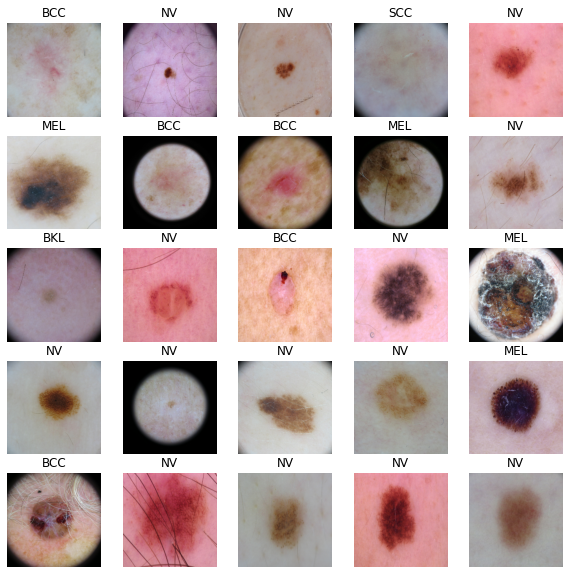

In [23]:
show_batch(image_batch.numpy(), label_batch.numpy(),classnames)

In [24]:
del gt_df
del fold_ds
del k_fold_ds

### Load New Ground truth CSV

In [122]:
#Load ground truth CSV
df=pd.read_csv('../.keras/datasets/ISIC_GT_With_Class_Type.csv')
df.head(2)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_class,class_type
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,Benign
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,Benign


In [123]:
total_imgs = len(df)
total_imgs

25331

In [124]:
df['class_type'] = pd.Categorical(df['class_type'])
# df['target_class'] = df.class_type.cat.codes

In [125]:
# df.dtypes

In [126]:
bgt_df = df.loc[df.class_type.cat.codes!=2,['image','image_class','class_type']].copy()
total = len(bgt_df)
# total
bgt_df.head()

,image,image_class,class_type
0,ISIC_0000000,NV,Benign
1,ISIC_0000001,NV,Benign
2,ISIC_0000002,MEL,Malignant
3,ISIC_0000003,NV,Benign
4,ISIC_0000004,MEL,Malignant


In [127]:
del df

In [128]:
y_true = np.zeros((total,2), dtype="float")
y_true[bgt_df.class_type.cat.codes==1,1] = 1
y_true[bgt_df.class_type.cat.codes==0,0] = 1
bgt_df['benign'] = y_true[:,0]
bgt_df['malignant'] = y_true[:,1]

In [129]:
bgt_df.head()

,image,image_class,class_type,benign,malignant
0,ISIC_0000000,NV,Benign,1.0,0.0
1,ISIC_0000001,NV,Benign,1.0,0.0
2,ISIC_0000002,MEL,Malignant,0.0,1.0
3,ISIC_0000003,NV,Benign,1.0,0.0
4,ISIC_0000004,MEL,Malignant,0.0,1.0


### Split into train and test

In [132]:
class_df_num = np.zeros((2,2),dtype="float")
split_ratio = [0.8,0.2]
classnames=['benign','malignant']
dataset = bgt_df[bgt_df[classnames[0]]==1.0]
train_df,test_df = train_test_val(len(dataset),split_ratio, dataset,val=False)
class_df_num[0,:] = [len(train_df),len(test_df)]

i=1
for classname in classnames[1:]:
    dataset = bgt_df[bgt_df[classnames[i]]==1.0]
    train,test = train_test_val(len(dataset),split_ratio, dataset,val=False)
    class_df_num[i,:] = [len(train),len(test)]
    train_df=train_df.append(train, ignore_index=True)
    test_df=test_df.append(test, ignore_index=True)
    
    i=i+1

In [133]:
class_df_num

array([[10300.,  2575.],
       [ 6779.,  1694.]])

In [134]:
print(len(train_df),len(test_df))

17079 4269


In [135]:
test_df.head()

,image,image_class,class_type,benign,malignant
0,ISIC_0031501,NV,Benign,1.0,0.0
1,ISIC_0010204,NV,Benign,1.0,0.0
2,ISIC_0031833,NV,Benign,1.0,0.0
3,ISIC_0025713,NV,Benign,1.0,0.0
4,ISIC_0062842,NV,Benign,1.0,0.0


In [136]:
del bgt_df

In [138]:
class_ds_num = np.zeros((2,1),dtype="float")
k_fold_ds = list()
k = 5


dataset = train_df[train_df[classnames[0]]==1.0]
n = len(dataset)
class_ds_num[0,:] = [n]
k_fold_ds = k_fold_split(k,dataset)

i=1
for classname in classnames[1:]:
    dataset = train_df[train_df[classname]==1.0]
    n = len(dataset)
    class_ds_num[i,:] = [n]
    class_fold_ds = k_fold_split(k,dataset)
    for j in range(k):
        k_fold_ds[j] = np.vstack((k_fold_ds[j],class_fold_ds[j]))
    i=i+1 

In [139]:
class_ds_num

array([[10300.],
       [ 6779.]])

In [140]:
# class_ds_num
k_fold_ds[4]

array([['ISIC_0066326', 'NV', 'Benign', 1.0, 0.0],
       ['ISIC_0013007_downsampled', 'NV', 'Benign', 1.0, 0.0],
       ['ISIC_0058105', 'NV', 'Benign', 1.0, 0.0],
       ...,
       ['ISIC_0024675', 'MEL', 'Malignant', 0.0, 1.0],
       ['ISIC_0033545', 'MEL', 'Malignant', 0.0, 1.0],
       ['ISIC_0056933', 'BCC', 'Malignant', 0.0, 1.0]], dtype=object)

In [143]:
def create_binary_ds(ndarr):    
    df = pd.DataFrame(data=ndarr[:,-2:],columns=classnames,dtype='float')
    df.head()
    df['image'] = src_dir +"/" + ndarr[:,0] +".jpg"
    dataset = tf.data.Dataset.from_tensor_slices((df['image'].values, df[classnames].values))
    return dataset

### Load Binary Dataset

In [144]:
fold_ds = create_binary_ds(k_fold_ds[0])

In [145]:
ds_size = k_fold_ds[0].shape[0]

In [146]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [147]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
fold_ds = fold_ds.map(process_data, num_parallel_calls=AUTOTUNE)

In [148]:
fold_ds = prepare_batches(fold_ds,shuffle_buffer_size=ds_size)

Understanding the data

In [149]:
image_batch, label_batch = next(iter(fold_ds))

In [150]:
image_batch.shape

TensorShape([32, 224, 224, 3])

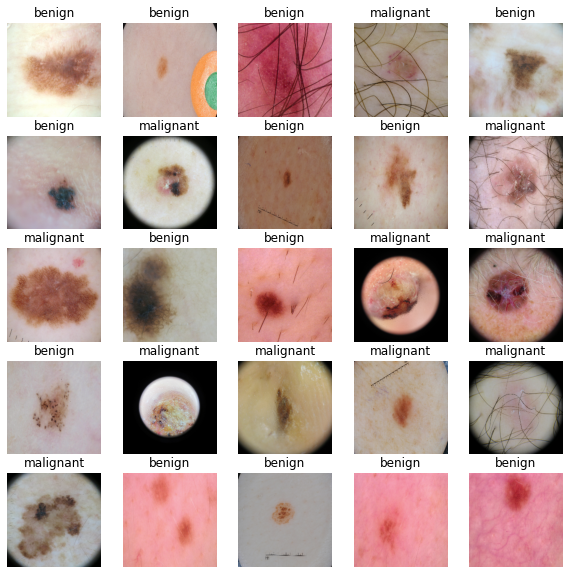

In [152]:
show_batch(image_batch.numpy(), label_batch.numpy(),classnames)